In [36]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast

In [37]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# Set up dataset parameters
dataset_path = '/content/drive/MyDrive/Jellyfish'
img_size = (224, 224)
batch_size = 32
seed = 42

# Load full dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    shuffle=True  # Shuffle before splitting
)

# Print class names
print("Class names:", full_ds.class_names)

Found 750 files belonging to 5 classes.
Class names: ['barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']


In [39]:
# Split dataset: 80% train, 20% test
dataset_size = len(full_ds)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)

print(f"Total batches: {dataset_size}")
print(f"Training batches: {train_size}")
print(f"Test batches: {test_size}")

Total batches: 24
Training batches: 19
Test batches: 5


In [40]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
])

# Apply augmentation
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

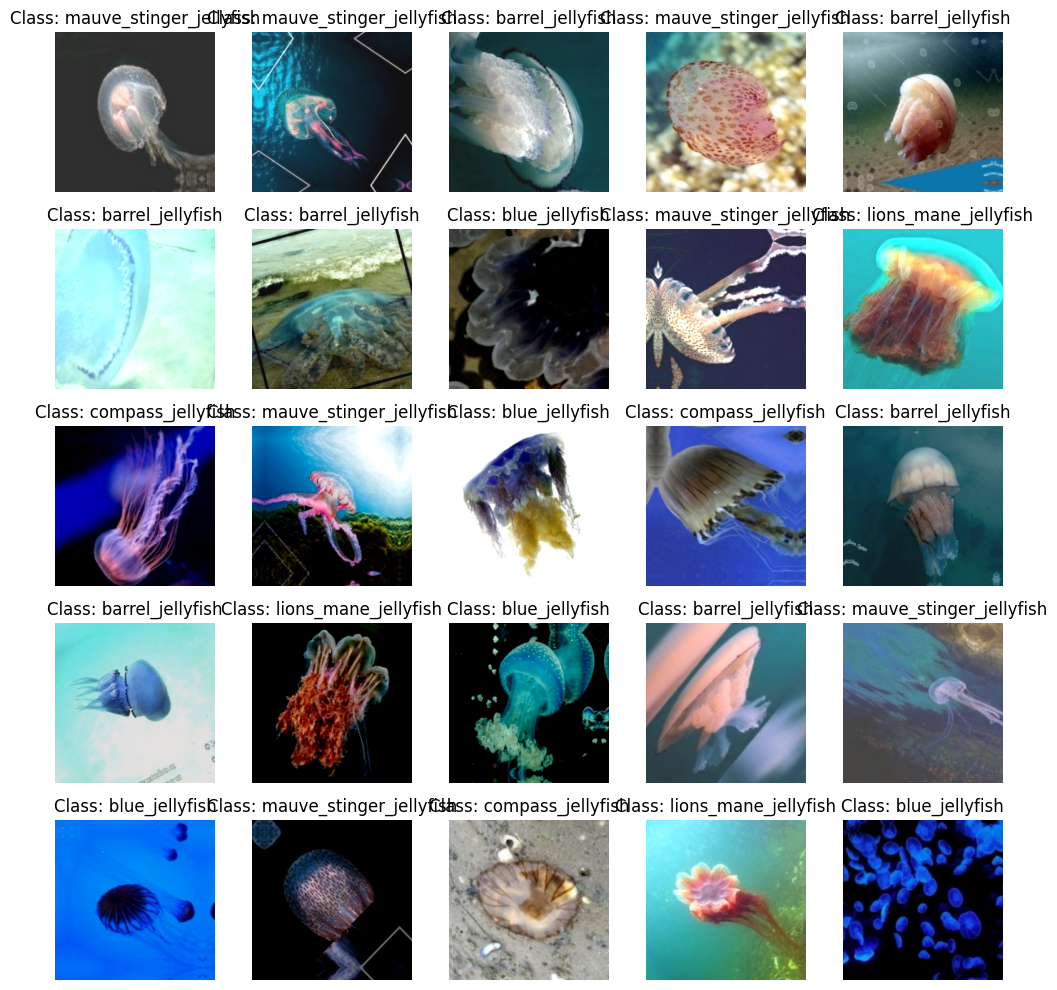

In [41]:
# Visualize augmented images
import matplotlib.pyplot as plt

# Take a single batch of images from the augmented training dataset
image_batch, label_batch = next(iter(augmented_train_ds))

# Number of images to display (25 in a 5x5 grid)
num_images_to_display = 25

# Create a 5x5 grid for the images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Iterate over the images in the batch
for i in range(num_images_to_display):
    ax = axes[i // 5, i % 5]  # Get the current subplot
    ax.imshow(image_batch[i].numpy().astype("uint8"))  # Display the image
    ax.set_title(f"Class: {full_ds.class_names[label_batch[i].numpy()]}")  # Set class name as title
    ax.axis("off")  # Turn off axes

plt.tight_layout()
plt.show()

In [42]:
# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [43]:
# Transfer Learning with VGG16
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the base model layers
base_model.trainable = False

# Create new model on top
transfer_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])

# Compile the model
transfer_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

transfer_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,757 (80.64 MB)

 Trainable params: 6,424,069 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.4156 - loss: 38.6116
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 410ms/step - accuracy: 0.7613 - loss: 3.3305
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 401ms/step - accuracy: 0.8703 - loss: 1.2431
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.8872 - loss: 0.6049
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step - accuracy: 0.9459 - loss: 0.4848
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step - accuracy: 0.9361 - loss: 0.4343
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.9256 - loss: 0.3927
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 430ms/step - accuracy: 0.9502 - loss: 0.2395
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 352ms/step - accuracy: 0.9170 - loss: 0.5378
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 400ms/step - accuracy: 0.9601 - loss: 0.2909
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 386ms/step - accuracy: 0.9596 - loss: 0.1540
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 344m

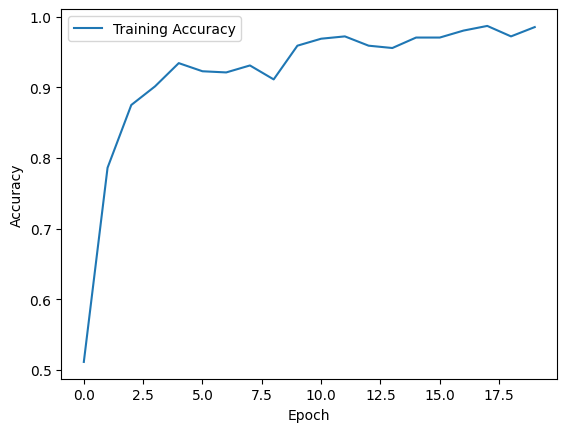

In [44]:
# Train the transfer learning model
transfer_history = transfer_model.fit(
    augmented_train_ds,
    epochs=20
)

# Evaluate on test set
test_loss, test_acc = transfer_model.evaluate(test_ds)
print(f"Transfer Learning Test Accuracy: {test_acc:.2f}")

# Plot training history
plt.plot(transfer_history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()